In [1]:
# Kaggle: Recursion Cellular Image Classification
# https://www.kaggle.com/leighplt/densenet121-pytorch
# https://stackoverflow.com/questions/43264816/need-help-combining-two-3-channel-images-into-6-channel-image-python
# https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/
# https://github.com/keras-team/keras/issues/4664
# https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/


# ResNet feature extraction
# https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet

# Reference: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8
# Reference: https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
import os
import numpy as np
np.random.seed(251)
os.environ['PYTHONHASHSEED']=str(251)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_openpose = 'openpose_output'
dir_train = 'NEW4_image_transfer_trial3'
dir_test = 'NEW4_manual_optical_flow_output_trial3'
model_name = 'ResNet50_model_weights_NEW4_trial3_model2.h5'

TRAIN_DIR = os.path.join(project_path, dir_openpose, dir_train)
# class_list = ['AGAIN', 'ALL', 'AWKWARD', 'BASEBALL', 'BEHAVIOR', 'CAN', 'CHAT', 'CHEAP', 
#               'CHEAT', 'CHURCH', 'COAT', 'CONFLICT', 'COURT', 'DEPOSIT', 'DEPRESS', 
#               'DOCTOR', 'DRESS', 'ENOUGH', 'NEG']
y_train_lst = [f.split('_')[1] for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) if 'train' in f]
class_list = np.unique(y_train_lst)
sample_class_weights = class_weight.compute_class_weight('balanced', class_list, y_train_lst)

HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 16
NUM_EPOCHS = 2
num_train_images = len([f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                        if 'train' in f])
print(num_train_images)

1155


In [3]:
# Reference: https://keras.io/preprocessing/image/
# Reference: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Below are the parameters used for crop
    # zoom_range=[0.8, 1.2], 
    # width_shift_range=[-50,50]
    # Below are the parameters used for no crop
    zoom_range=[0.7, 1.3], 
    # width shift means up and down
    width_shift_range=0.2,
    height_shift_range = 0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
# base_output = base_model.layers[-1].output
base_output = base_model.layers[5].output
base_output = Flatten()(base_output)
base_model = Model(base_model.input, output=base_output)

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.trainable = True
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name in ['res5c_branch2c']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
        
# layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)

Found 1155 images belonging to 19 classes.


C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`


In [4]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 306, 306, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 64)      9472      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 150, 150, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 64)      0         
_________________________________________________________________
pool1_pad (ZeroPadding2D)    (None, 152, 152, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1478656)           0   

In [5]:
model = Sequential()
model.add(base_model)
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(class_list), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
model.summary()

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, class_weight=dict(enumerate(sample_class_weights)))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 1478656)           9728      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1478656)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                28094483  
Total params: 28,104,211
Trainable params: 28,094,483
Non-trainable params: 9,728
_________________________________________________________________
Epoch 1/2
72/72 [==============================] - 58s 805ms/step - loss: 18.6962 - accuracy: 0.0500
Epoch 2/2
72/72 [==============================] - 59s 819ms/step - loss: 10.4207 - accuracy: 0.0685


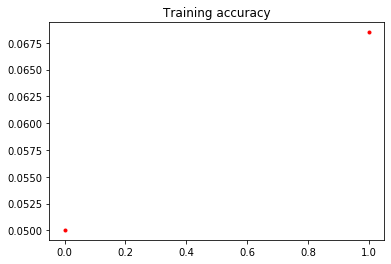

In [6]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.title('Training accuracy')
    plt.show()

plot_training(history)


In [7]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
# model_saved = load_model(os.path.join(project_path, model_name))
# model_saved = finetune_model
model_saved = model
def conv_index_to_vocab(ind):
    temp_dict = dict(enumerate(class_list))
    return temp_dict[ind]
def conv_vocab_to_index(vocab):
    temp_dict = dict(zip(class_list,range(len(class_list))))
    return temp_dict[vocab]

print(conv_index_to_vocab(0))
print(conv_vocab_to_index('NEG'))

AGAIN
18


In [8]:
correct_count = 0
count = 0
# test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
#                   if 'test' in f and 'sim0' in f]
test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                  if 'test' in f]
for file in test_files_lst:
    img = image.load_img(os.path.join(project_path,dir_openpose, dir_test,file), target_size=(300, 300))
    x = image.img_to_array(img)
    print(x.shape)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    x = preprocess_input(x)
    y_pred = model_saved.predict(x)
    print('-----------------')
    print('Actual: ', file.split('_')[1])
    print('Prediction: ', conv_index_to_vocab(np.argmax(y_pred)))
    # print(y_pred)
    count += 1
    if file.split('_')[1] == conv_index_to_vocab(np.argmax(y_pred)):
        correct_count += 1 
    if count > 20:
        break

(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DEPRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DEPRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DEPRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  AGAIN
Prediction:  DRESS
(300, 300, 3)
(1, 300, 300, 3)
-----------------
Actual:  ALL
Prediction:  DRESS


In [9]:
print(correct_count)
print(len(test_files_lst))


0
253
